# A Tale of Two Futures: A Comparison of Communist vs. Capitalist Philosophers

In this project, we will be using a dataset complied for the 'Philosophy Data Project'. While the corpus includes over 50 authors across ideology and time-period, I am interested in analyzing the texts of two heavily debated schools of thought: Communism and Capitalism. Specifically, I want to see if there are statistically significant differences in the text construction and sentiments expressed by authors of these ideologies. My project aims to evaluate each author across three criteria:

1. Text Characteristics - What is the average sentence length across schools and authors?
2. Sentence Structure - What is weighted average usage of nouns, adjectives, and verbs across schools and authors?
3. Sentence Polarity - What is the polarity breakdown of sentences in each school?
3. Emotional Connotations - What are the primary emotions evoked by each school?

With the above criteria, I intend to deduce whether the numbers of each author would naturally align with tenets of their corresponding schools.

## Importing Libraries and Dataset

First, let's import the libraries and the dataset needed to conduct our analysis.

In [1]:
#Import Dataset/frame Libraries 
import opendatasets as od
import os 
import pandas as pd
import string
import warnings

warnings.filterwarnings('ignore')

#Import Visualization Packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches

#Natural Language Processing Packages
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('vader_lexicon')
import text2emotion as te
from nrclex import NRCLex

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ananyatinaikar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ananyatinaikar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ananyatinaikar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ananyatinaikar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ananyatinaikar/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ananyatinaikar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nlt

In [2]:
#Kaggle Dataset URL
dataset = "https://www.kaggle.com/datasets/kouroshalizadeh/history-of-philosophy"

#Open Dataset
#Username: ananyatinaikar | Password: 954c9308b95461d07590d5315741fbbd
od.download(dataset)

#File directory
data_dir = './history-of-philosophy'

#Read csv file to dataframe
df = pd.read_csv(data_dir + '/philosophy_data.csv')

print("******************************************")
print("Dataset successfully imported.")

Skipping, found downloaded files in "./history-of-philosophy" (use force=True to force download)
******************************************
Dataset successfully imported.


## Understanding the Corpus

Now that we have our dataset, we can filter for line items that are associated with either the Communist or Capitalist schools. From there, we can see the basic structural characteristics of our corpus:

In [3]:
df = df[(df['school']=='capitalism') | (df['school']=='communism')]
comcap_df = pd.DataFrame(df.groupby('title')['school'].unique()).reset_index()
comcap_df = comcap_df.merge(pd.DataFrame(df.groupby('title')['author'].unique()).reset_index())
comcap_df = comcap_df.merge(pd.DataFrame(df.groupby('title').size()).reset_index().rename(columns={0:'total_rows'}))
comcap_df = comcap_df.sort_values(by=['school'])

print('********Dataset Characteristics**********')
print('Data Dimensions - Rows, Columns: ' + str(df.shape))
print('Authors: ' + str(len(df.author.unique())))
print('Total Titles: ' + str(len(df.title.unique())))

comcap_df.style.set_caption("Corpus Breakdown by Author").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '16px')]}])

********Dataset Characteristics**********
Data Dimensions - Rows, Columns: (36152, 11)
Authors: 5
Total Titles: 6


,title,school,author,total_rows
0,"A General Theory Of Employment, Interest, And Money",['capitalism'],['Keynes'],3411
3,On The Principles Of Political Economy And Taxation,['capitalism'],['Ricardo'],3090
5,The Wealth Of Nations,['capitalism'],['Smith'],11693
1,Capital,['communism'],['Marx'],12996
2,Essential Works Of Lenin,['communism'],['Lenin'],4469
4,The Communist Manifesto,['communism'],['Marx'],493


From the above, we can see that the text size varies across authors. We will need to account for this in our analysis later on. Furthermore, the Marx corpus includes texts from two titles. For the sake of uniformity, I've decided to remove the shorter of the two titles, 'The Communist Manifesto', from our analysis so that only one text per author is evaluated

In [4]:
df = df[(df['title']!='The Communist Manifesto')]
comcap_df = comcap_df[comcap_df['title']!='The Communist Manifesto']

print('********Final Dataset Characteristics**********')
print('Data Dimensions - Rows, Columns: ' + '(' + str(comcap_df['total_rows'].sum()) + "," + str(df.columns.size) + ")")
print('Authors: ' + str(len(comcap_df.author)))
print('Total Titles: ' + str(len(comcap_df.title.unique())))

comcap_df.style.set_caption("Final Corpus Breakdown by Author").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '16px')]}])

********Final Dataset Characteristics**********
Data Dimensions - Rows, Columns: (35659,11)
Authors: 5
Total Titles: 5


,title,school,author,total_rows
0,"A General Theory Of Employment, Interest, And Money",['capitalism'],['Keynes'],3411
3,On The Principles Of Political Economy And Taxation,['capitalism'],['Ricardo'],3090
5,The Wealth Of Nations,['capitalism'],['Smith'],11693
1,Capital,['communism'],['Marx'],12996
2,Essential Works Of Lenin,['communism'],['Lenin'],4469


## Criteria 1: Text Characteristics

It is generally understood that shorter sentences are a common trait of persuasive, impactful writing. In this section, we will evaluate the spread and centers of the sentence length of texts in each school. 

In [5]:
#Define a new dataset 
auth_length = df[['school','title','author','sentence_lowered']]

#Clean sentences for punctuation
translator = str.maketrans('', '', string.punctuation)
auth_length['sentence_lowered'].apply(lambda x: x.translate(translator))

#Count words in each Sentence
auth_length['word_in_sen'] = auth_length['sentence_lowered'].str.split().str.len()

Capitalism - Std. Dev of Sentence Length: 18.960137627323032
Communism - Std. Dev of Sentence Length: 17.411772901344676


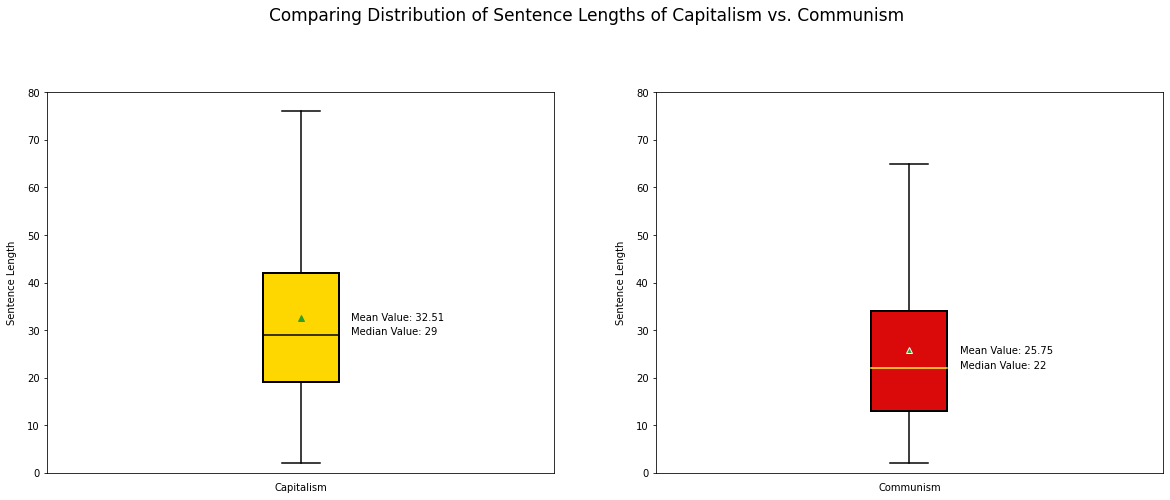

In [6]:
#Create subplots to compare author by school, side by side 
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,7))
fig.suptitle('Comparing Distribution of Sentence Lengths of Capitalism vs. Communism', fontsize=17, y=1.05)


#Retrieve sentence length Y(values) filtered by Author (Communism = Marx/Lenin and Capitalism=Keynes/Ricardo/Smith))
capitalist = auth_length[(auth_length['author']=='Keynes') |(auth_length['author']=='Ricardo')|(auth_length['author']=='Smith')]['word_in_sen']
communist = auth_length[(auth_length['author']=='Marx') |(auth_length['author']=='Lenin')]['word_in_sen']


#Median
median = auth_length.groupby('school')['word_in_sen'].median()
mean = round(auth_length.groupby('school')['word_in_sen'].mean(),2)
vertical_offset = auth_length['word_in_sen'].median() * 0.05

#Plot Capitalism Author Distributions
box1 = ax1.boxplot(capitalist, patch_artist=True,boxprops=dict(facecolor="#FFD700",linewidth=2.0),medianprops=dict(linewidth=1.5,color="black"),
            whiskerprops=dict(linewidth=1.5),capprops=dict(linewidth=1.5), showfliers=False,zorder=0,showmeans=True)
ax1.set_xlabel('Capitalism', labelpad=10)
ax1.set_xticks([])
ax1.set_ylim(0,80)
ax1.set_ylabel('Sentence Length',labelpad=10)
ax1.text(1.1,29,'Median Value: ' + str(median[0]),fontweight=40)
ax1.text(1.1,32,'Mean Value: ' + str(mean[0]))

#Plot Communism Author Distributions
ax2.boxplot(communist,patch_artist=True,boxprops=dict(facecolor="#da0a0a",linewidth=2.0),medianprops=dict(linewidth=1.5,color="#faf333"),
            whiskerprops=dict(linewidth=1.5),capprops=dict(linewidth=1.5),showfliers=False,zorder=0,showmeans=True, meanprops=dict(markeredgecolor="white"))
ax2.set_xlabel('Communism', labelpad=10)
ax2.set_xticks([])
ax2.set_ylim(0,80)
ax2.set_ylabel('Sentence Length',labelpad=10)
ax2.text(1.1,22,'Median Value: ' + str(median[1]),zorder=10,color='black',fontweight=40)
ax2.text(1.1,25,'Mean Value: ' + str(mean[1]))

#Adding Std. Dev of Sentence Length by School to each Chart
cap_dev = auth_length[auth_length['school']=='capitalism']['word_in_sen'].std()
com_dev = auth_length[auth_length['school']=='communism']['word_in_sen'].std()

print('Capitalism - Std. Dev of Sentence Length: ' + str(cap_dev))
print('Communism - Std. Dev of Sentence Length: ' + str(com_dev))

plt.show()

From the above, both the mean and median sentence lengths of Capitalist authors are larger than their Communist counterparts. Beyond that, the sentence lengths in Capitalist authors spans a greater range, with a larger proportion falling in the upper quartile of the dataset. This is further strengthened by the standard deviation stats printed at the top. It looks like our Capitalist authors exhibit a slightly greater std. dev in sentence length than that of Communists. 

It is clear from our graph that Capitalist authors are writing longer sentences than their Communist counterparts. However, let's take a look at the sentence lengths broken out by Author to see if any more details are revealed. Given that these are large texts, we are going to remove sentences of outlier length (i.e. 1.5 * IQR). Below I've captured those boundaries for each school:

In [7]:
#Define Function to Retrieve IQR + Calculate Outlier Boundaries
quartile_3 = 0

def get_iqr_statistics(dataset):
    quartile_1 = np.round(dataset.quantile(0.25), 2)
    quartile_3 = np.round(dataset.quantile(0.75), 2)
    iqr = np.round(quartile_3 - quartile_1, 2)

    print('25th percentile: %s' % quartile_1)
    print('75th percentile: %s' % quartile_3)
    print('Interquartile range (IQR): %s' % iqr)
    print('\033[1m' + 'Outlier Boundaries:' + '\033[1m' + '(' + str(quartile_1 - (1.5 * iqr)) + "," + str(quartile_3 + (1.5 * iqr)) + ")")
    print('\033[0m')

print('\n*****Capitlist Author IQR Statistics*****')
get_iqr_statistics(capitalist)

print('*****Communist Author IQR Statistics*****')
get_iqr_statistics(communist)



*****Capitlist Author IQR Statistics*****
25th percentile: 19.0
75th percentile: 42.0
Interquartile range (IQR): 23.0
Outlier Boundaries:(-15.5,76.5)

*****Communist Author IQR Statistics*****
25th percentile: 13.0
75th percentile: 34.0
Interquartile range (IQR): 21.0
Outlier Boundaries:(-18.5,65.5)



Now let's visualize our sentence lengths by author to get a closer look. We will remove any sentences of outlier length per the boundaries defined above. Since there are no sentences with negative length, we will only filter using the upper outlier boundaries.

In [8]:
cap_nooutliers = auth_length[(auth_length['school']=='capitalism') & (auth_length['word_in_sen'] < 76.5)]
cap_auth_mean = pd.DataFrame(auth_length[auth_length['school']=='capitalism'].groupby('author')['word_in_sen'].mean()).reset_index()

com_nooutliers = auth_length[(auth_length['school']=='communism') & (auth_length['word_in_sen'] < 65.5)]
com_auth_mean = pd.DataFrame(round(auth_length[auth_length['school']=='communism'].groupby('author')['word_in_sen'].mean(),2)).reset_index()

Text(27.0, -0.55, 'Communist Authors')

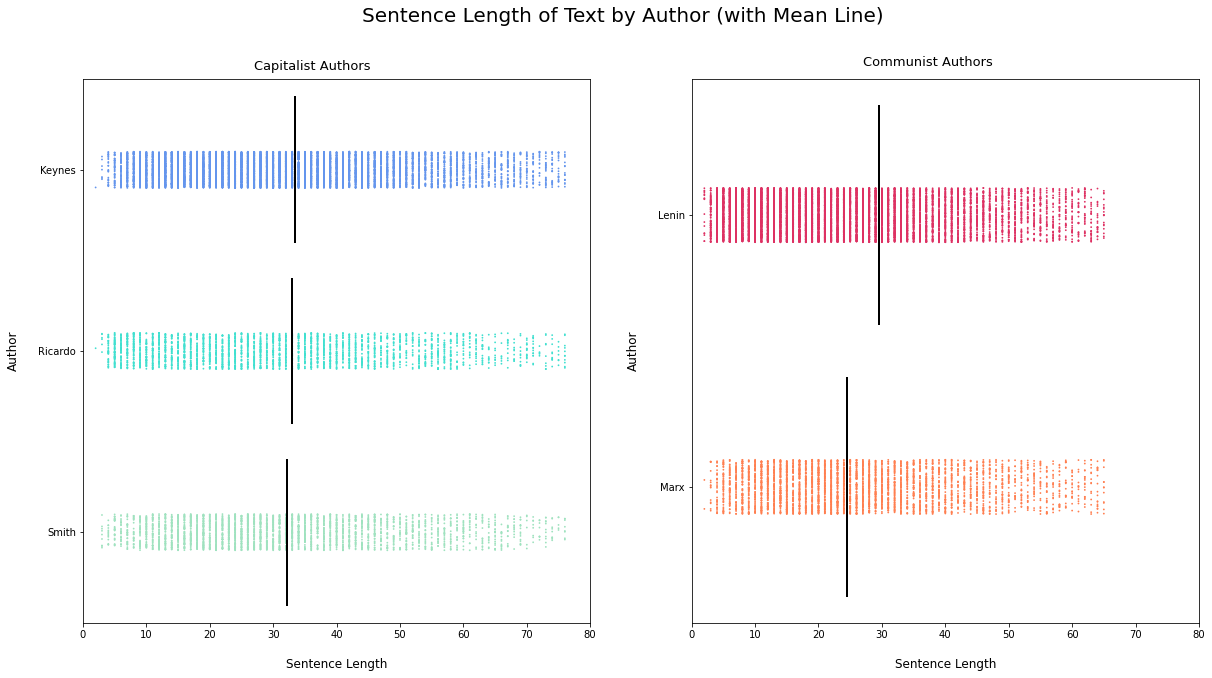

In [9]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
fig.suptitle('Sentence Length of Text by Author (with Mean Line)', fontsize=20)

sns.stripplot(x=cap_nooutliers['word_in_sen'], y=cap_nooutliers['author'], s=1.8, ax=ax[0], palette=['#6495ED','#40E0D0','#9FE2BF'])
sns.stripplot(x=com_nooutliers['word_in_sen'], y=com_nooutliers['author'], s=1.8, ax=ax[1], palette=['#DE3163','#FF7F50'])

sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'black', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x=cap_auth_mean['word_in_sen'],
            y=cap_auth_mean['author'],
            data=cap_auth_mean,
            showfliers=False,
            showbox=False,
            showcaps=False, ax=ax[0])

sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'black', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x=com_auth_mean['word_in_sen'],
            y=com_auth_mean['author'],
            data=com_auth_mean,
            showfliers=False,
            showbox=False,
            showcaps=False, ax=ax[1])

ax[0].set_ylabel('Author',fontsize=12, labelpad=18)
ax[1].set_ylabel('Author',fontsize=12, labelpad=18)
ax[0].set_xlabel('Sentence Length',fontsize=12, labelpad=18)
ax[1].set_xlabel('Sentence Length',fontsize=12, labelpad=18)
ax[0].set_xlim(0,80)
ax[1].set_xlim(0,80)


#Add Std. Dev of Sentence Length by Author for each Graph
cap_auth_dev = auth_length[auth_length['school']=='capitalism'].groupby('author')['word_in_sen'].std()


ax[0].text(27.0,-0.55,'Capitalist Authors', fontsize=13)
ax[1].text(27.0,-0.55, 'Communist Authors', fontsize=13)


From the above, we can see that the mean sentence length of capitalist authors, though higher as a whole, does not vary much from author to author. Conversely, there is higher difference of average sentence length between Communist authors. As a whole however, we can assume that Communist writers tend to write shorter, more impactful sentences than Capitalists.

While these text visualizations give us a cursory view of the school/author writing style, we can now go one step further and evaluate the types of words being used in the texts. We will go into this in our next section.

## Criteria 2: Sentence Structure

In this section, we will begin to break down the types of speech found in the sentences of each author. For this analysis, I  I will be using the NLTK Python package to categorize the words in each sentence. While the package offers a variety of speech tags, I will be focused on identifying the following:

* Nouns - To what extent is the author's text discussing people, ideas, concepts
* Adjectives - To what extent does the author's text rely on descriptive imagery
* Verbs - To what extent is the author's text action-oriented 

We will start by listing out the speech tags we are interested in capturing and defining a list of store our authors:

In [10]:
#Codes per NLTK documentation (Penn-Treebank Tags)
adjective_tags = ['JJ','JJR', 'JJS', 'RB', 'RBR', 'RBS'] #descriptive imagery
noun_tags = ['NN', 'NNS', 'NNP', 'NNPS'] #ideas/concepts 
verb_tags = ['VB','VBD', 'VBG', 'VBN', 'VBP', 'VBZ'] #actionability 

#Get unique author list and empty list to store verb counts 
authors = sorted(list(df.author.unique()))

We then need to define a function to lemmatize the sentences in our text. Lemmatization will ensure the words are evaluated using their base form and ensure in a more accurate evaluation of our text. 

In [11]:
lemmatizer = WordNetLemmatizer()

#Function to Lemmatize Text
def lemmatize_text(text):
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(words)

Next, I will  define a function to iterrate through our dataframe to evaluate each sentence of a specified author. Earlier we noted that the text size varies across authors. Therefore, it is not enough to simply count the occurences of nouns, adjectives, and verbs. Instead, I will need to weight the count of speech tags in a sentence by the total number of words in that sentence. 

As seen below, my function takes in a list of speech codes (defined above) and first, lemmatizes our sentences using the lemmatize_text() function. Next, it tags the words in each lemmatized sentence of the text. We then count the number of tags in each sentence and divide that by the total number of words in the sentence. This gives us a percentage (i.e. score) for each sentence. We sum up the scores and divide them by the total number of sentences in the text. We do this for every author in our corpus. 

In [12]:
#Define Function with input 'tagtype' (i.e. lists of tag codes defined above)
#Create output dataframe with total tagtypes per author 
def tag_score(tagtype):
    scores = []
    
    for author in authors:
        print('Generating Speech Tags for ' + str(author))
        tag_df = df[df['author']==str(author)][['sentence_lowered']]
        tag_df['lem_sen'] = tag_df['sentence_lowered'].apply(lemmatize_text)
        tag_df['tokenized'] = tag_df['sentence_lowered'].apply(nltk.word_tokenize)
        tag_df['pos_tags'] = tag_df['tokenized'].apply(nltk.pos_tag)
        tag_df['tag_type'] = tag_df['pos_tags'].apply(lambda x: [word for word, tag in x if tag in tagtype])
        tag_df['tag_count'] = tag_df['tag_type'].apply(lambda x: len(x))
        tag_df['words_in_sen'] = tag_df['sentence_lowered'].str.split().str.len()
        tag_df['weighted_tag_count'] = tag_df['tag_count']/tag_df['words_in_sen'] #weighting each sentence by number of words in sentence
        
        score = (tag_df['weighted_tag_count'].sum()/len(tag_df.index))* 100 #score is sum of percentages by total number of sentences
        scores.append(score)
    
    author_score = pd.DataFrame(authors, columns=['author'])
    author_score['tag_score'] = scores
    
    return author_score

In [13]:
#Run Score Function
verbs = tag_score(verb_tags)
adjectives = tag_score(adjective_tags)
nouns = tag_score(noun_tags)

print('Speech Tags have successfully generated!')

#Add our scores to a singluar dataset for visualization
score_df = verbs
score_df = round(score_df.rename(columns={'tag_score':'verb_score'}),2)
score_df['adj_score'] = round(adjectives['tag_score'],2)
score_df['noun_score'] = round(nouns['tag_score'],2)
score_df['school'] = np.where((score_df['author']=='Marx')|(score_df['author']=='Lenin'), 'communism','capitalism')

Let's visualize these scores for each author:

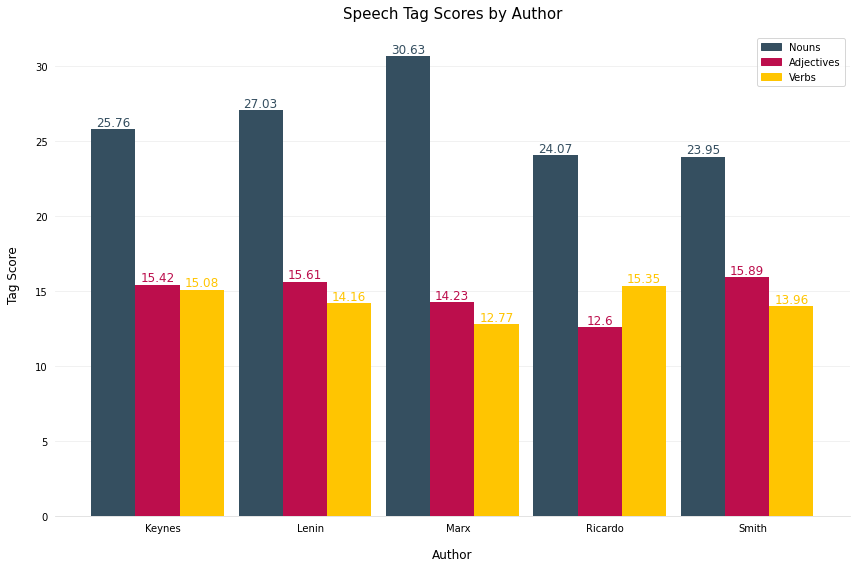

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(score_df.author.unique()))
bar_width = 0.3

b1 = ax.bar(x - bar_width,score_df['noun_score'],width=0.3,color='#354F60')
b2 = ax.bar(x,score_df['adj_score'],width=0.3, color='#BC0E4C')
b3 = ax.bar(x + bar_width,score_df['verb_score'], color='#FFC501', width=0.3)

ax.set_xticks(x + bar_width / 8)
ax.set_xticklabels(score_df.author.unique())

#Legend
noun_line = mpatches.Patch(color='#354F60', label='Nouns')
adj_line = mpatches.Patch(color='#BC0E4C', label='Adjectives')
verb_line = mpatches.Patch(color='#FFC501', label='Verbs')
ax.legend(handles=[noun_line,adj_line,verb_line])

# Axis styling.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add axis and chart labels.
ax.set_xlabel('Author', labelpad=15,fontsize=12)
ax.set_ylabel('Tag Score', labelpad=15,fontsize=12)
ax.set_title('Speech Tag Scores by Author', pad=15, fontsize=15)

fig.tight_layout()

for bar in ax.patches:
  bar_value = bar.get_height()
  text = f'{bar_value:,}'
  text_x = bar.get_x() + bar.get_width() / 2
  text_y = bar.get_y() + bar_value
  bar_color = bar.get_facecolor()
  ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
          size=12)

Some preliminary observations given the graph above:

* <i>Nouns</i> - It looks like all authors are using more nouns than either adjectives or verbs. However, we can note that both Communist writers, Marx and Lenin, have higher noun scores that their Capitalist counterparts. One could infer that these texts are more focused on people, places, and ideals.
<p></p>
* <i>Adjectives</i> - There doesn't seem to be a trend across schools for use of adjectives. We see that the highest usage of adjectives is Smith, followed by Lenin. This suggests that these two authors are perhaps relying on descriptive imagery to tell their version of the future.
<p></p>
* <i>Verbs</i> - Similar to adjectives, there isn't a clear trend of adjective usage across schools. We see that Ricardo and Keynes, both capitalist authors, have the first and second highest usage of verbs. While Smith does not seem to use verbs as much, he is still higher than Marx, his communist contemporary. This could indicate that Capitalist texts tend to be more action-oriented.

Let's compare the average scores across schools and see if the above observations are supported:

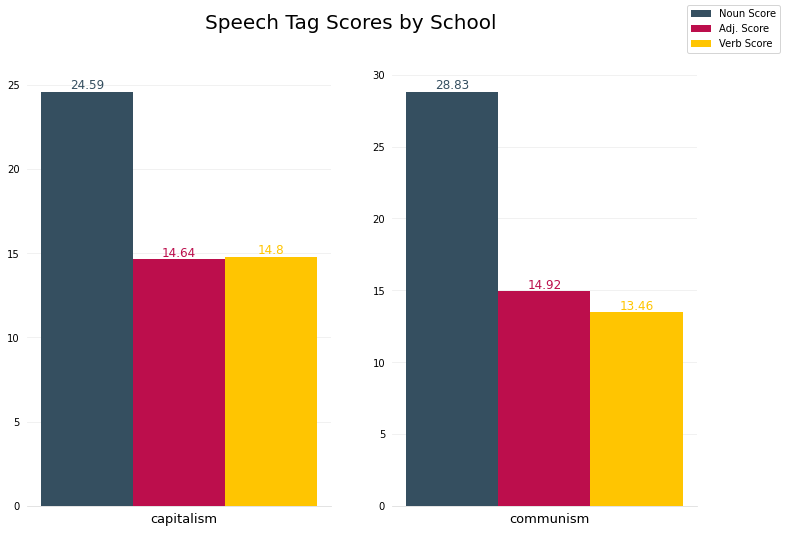

In [15]:
#Group Average Scores by School
school_score_df = round(score_df.groupby('school')[['noun_score','adj_score','verb_score']].mean(),2).reset_index()
cap_score_df = pd.DataFrame(school_score_df[school_score_df['school']=='capitalism'])
com_score_df = pd.DataFrame(school_score_df[school_score_df['school']=='communism'])

#Plot subplots
fig, axs = plt.subplots(1,2,figsize=(12, 8))
plt.suptitle('Speech Tag Scores by School', fontsize=20, ha='center')

x = np.arange(len(cap_score_df.school.unique()))
bar_width = 0.3

#Define the Graphs
a = axs[0].bar(x - bar_width,cap_score_df['noun_score'],width=0.3,color='#354F60')
b = axs[0].bar(x,cap_score_df['adj_score'],width=0.3, color='#BC0E4C')
c = axs[0].bar(x + bar_width,cap_score_df['verb_score'], color='#FFC501', width=0.3)
axs[0].set_xticks(x + bar_width / 20)
axs[0].set_xticklabels(cap_score_df.school.unique(),fontsize=13)

axs[1].bar(x - bar_width,com_score_df['noun_score'],width=0.3,color='#354F60')
axs[1].bar(x,com_score_df['adj_score'],width=0.3, color='#BC0E4C')
axs[1].bar(x + bar_width,com_score_df['verb_score'], color='#FFC501', width=0.3)
axs[1].set_xticks(x + bar_width / 20)
axs[1].set_xticklabels(com_score_df.school.unique(), fontsize=13)

#Axis Styling
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)
    for bar in ax.patches:
      bar_value = bar.get_height()
      text = f'{bar_value:,}'
      text_x = bar.get_x() + bar.get_width() / 2
      text_y = bar.get_y() + bar_value
      bar_color = bar.get_facecolor()
      ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
              size=12)

#Legend
fig.legend([a,b,c],['Noun Score', 'Adj. Score','Verb Score'], loc='upper right')

It looks like the above graph confirms the observations we've detailed in the prior section. Communist writers seem to have texts that are more focused on people, places, and concepts (nouns). Capitalist writers seem to produce texts that are more action-oriented (verbs). There is a marginal difference in the use of adjectives across both schools, suggesting that they equally rely on descriptive imagery to tell their stories.

## Criteria 3: Sentence Polarity

In this section, we will explore the polarity scores of sentences in the texts of each author. Polarity refers to the overall sentiment conveyed by a particular text, phrase or word. I will be using the NLTK VADER package for my analysis. VADER produces four sentiment measurements. The initial three, positive, neutral, and negative, address the extent of the content that falls into pre-defined classifications. The last measurement, the compound score, is the total amount of the lexicon grades which have been normalized to run between – 1 and 1.

First, we will need to clean our sentences to  remove 'stop words'. Stop words are articles used in the English language like “the”, “a”, “at”, “for”, “above”, “on”, “is”, “all”. This was not a consideration in our previous section since we were specifically looking at nouns, adjectives, and verbs. Since we are now analyzing the polarity of the entire sentence, we need to remove these inconclusive words.

We will use the previous lemmatize_Text() function in conjunction with a new function (defined below) to remove stop words:

In [16]:
stop_words = set(stopwords.words("english"))

def remove_stopwords(text):
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha()]
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

sen_pol = df[['author','school','sentence_lowered']]
sen_pol['lem_sen'] = sen_pol['sentence_lowered'].apply(lemmatize_text)
sen_pol['sentence_clean'] = sen_pol['lem_sen'].apply(remove_stopwords)

Once we have our cleaned sentences, we can instantiate the NLTK SentimentIntensityAnalyzer and extract the polarity scores for each sentence: 

In [17]:
sia = SentimentIntensityAnalyzer()

sen_pol['polarity'] = sen_pol['sentence_clean'].apply(lambda x: sia.polarity_scores(x))

#Extract Polarity
sen_pol['neg'] = sen_pol['polarity'].apply(lambda d: d['neg'])
sen_pol['neu'] = sen_pol['polarity'].apply(lambda d: d['neu'])
sen_pol['pos'] = sen_pol['polarity'].apply(lambda d: d['pos'])
sen_pol['compound'] = sen_pol['polarity'].apply(lambda d: d['compound'])
sen_pol['sen_len'] = sen_pol['sentence_clean'].str.split().str.len()

I will then group the sentences into their respective schools. Given that these are large datasets, I am going to remove outliers on two fronts: (1) Compound Score; (2) Sentence Length. I can call the get_iqr_statistics() function I defined earlier to determine the outlier boundaries for the compound scores. I will then filter the compound scores and sentence length of each data set.

In [18]:
cap_compound = sen_pol[(sen_pol['author']=='Keynes') | (sen_pol['author']=='Ricardo') | (sen_pol['author']=='Smith')]
com_compound = sen_pol[(sen_pol['author']=='Marx') | (sen_pol['author']=='Lenin')]

print('\n*****Capitlist Author Compound Score IQR Statistics*****')
get_iqr_statistics(cap_compound['compound'])
cap_compound_out = cap_compound[(cap_compound['compound'] < 1.625) & (cap_compound['compound'] > -0.975)]
cap_compound_out = cap_compound_out[cap_compound['sen_len'] < 65.5]

print('\n*****Communist Author Compound Score IQR Statistics*****')
get_iqr_statistics(com_compound['compound'])
com_compound_out = com_compound[(com_compound['compound'] < 1.1) & (com_compound['compound'] > -0.66)]
com_compound_out = com_compound_out[com_compound['sen_len'] < 76.5]

print('Outliers have been removed from datasets')


*****Capitlist Author Compound Score IQR Statistics*****
25th percentile: 0.0
75th percentile: 0.65
Interquartile range (IQR): 0.65
Outlier Boundaries:(-0.9750000000000001,1.625)


*****Communist Author Compound Score IQR Statistics*****
25th percentile: 0.0
75th percentile: 0.44
Interquartile range (IQR): 0.44
Outlier Boundaries:(-0.66,1.1)

Outliers have been removed from datasets


Now we can visualize the compound sentiment scores of our two schools of thought using a density graph. We can also print out some average statistics for each school to supplement our graph (these statistics include outliers).

          Capitalist Sentiment Scores        Average Communist Sentiment Scores

Negative: 0.067                              0.068
Neutral:  0.735                              0.788
Positive: 0.198                              0.145
Compound: 0.287                              0.144


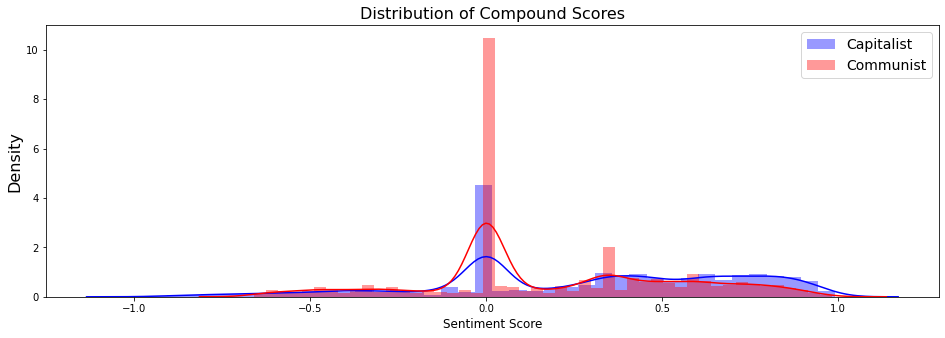

In [19]:
#Printing out Statistics
print('          Capitalist Sentiment Scores' + '        ' + 'Average Communist Sentiment Scores\n')

print('\033[1m' + 'Negative: ' + '\033[0m' + str(round(cap_compound['neg'].mean(),3)) + '                              ' + str(round(com_compound['neg'].mean(),3)))
print('\033[1m' + 'Neutral:  ' + '\033[0m' + str(round(cap_compound['neu'].mean(),3)) + '                              ' + str(round(com_compound['neu'].mean(),3)))
print('\033[1m' + 'Positive: ' + '\033[0m' + str(round(cap_compound['pos'].mean(),3)) + '                              ' + str(round(com_compound['pos'].mean(),3)))
print('\033[1m' + 'Compound: ' + '\033[0m' + str(round(cap_compound['compound'].mean(),3)) + '                              ' + str(round(com_compound['compound'].mean(),3)))


#Plotting Density Graph
fig, ax = plt.subplots(figsize=(16,5))

dens1 = sns.distplot(cap_compound_out['compound'], label='Capitalist', color='blue')
dens2 = sns.distplot(com_compound_out['compound'], label='Communist', color='red')

plt.title('Distribution of Compound Scores', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=12)
plt.legend(prop=dict(size=14))

From the graph and statistics above, we can deducate that the Communist texts are comprised of sentences that are more neutral than Capitalist texts. It appears that Capitalist texts tend to convey more positive sentiments and conversely, Communist texts are slightly more negative. This aligns with my understanding of Capitalism as a quixotic ideology, where as Communism (which was born out of a critique to Capitalism) paints a more pessimistic future. That being said, the compound scores of both schools are in the 'positive' range. This also aligns with the fact that the authors are writing with the intention of persuading the reader to accept their view point. 

## Criteria 4: Emotional Connotation

In this section, we will evaluate each author and the overall schools on the emotions evoked by their texts. I will be focused on the 6 universal emotions as validated by Paul Ekman in his 1970 study (see reference below): Fear, Joy, Sadness, Disgust, Anger, and Surprise. 

For this analysis, I will use the NCRLex package to measure the emotional affect of the texts. I will be evaluating the previously cleaned sentences (i.e. lemmatized and no stop words) of each author. Given that the NCRLex package only accepts string inputs, I will first need to define a function to convert the sentences associated with each author to string. I can then feed that string input to the NCRLex() object to return the emotional affects and their raw counts.

In [244]:
authors = sen_pol.author.unique().tolist()
emotionlist = []

def emotion_score():
    
    for author in authors:
        print('Generating Emotional Scores for ' + str(author))
        emo_df = sen_pol[sen_pol['author']==str(author)][['sentence_clean']]
        series = emo_df['sentence_clean']

        stringlist = []

        for row in series:
            stringlist.append(row)
    
        text_column = '. '.join(stringlist)
        emotion = NRCLex(text_column)
        emotionlist.append(emotion.raw_emotion_scores)

In [245]:
emotion_score()

print('Emotion Scores have successfully generated!')
emo_df = pd.DataFrame(authors,columns=['author'])
emo_df['emo_scores'] = emotionlist
emo_df['fear'] = emo_df['emo_scores'].apply(lambda d: d['fear'])
emo_df['joy'] = emo_df['emo_scores'].apply(lambda d: d['joy'])
emo_df['sadness'] = emo_df['emo_scores'].apply(lambda d: d['sadness'])
emo_df['disgust'] = emo_df['emo_scores'].apply(lambda d: d['disgust'])
emo_df['anger'] = emo_df['emo_scores'].apply(lambda d: d['anger'])
emo_df['surprise'] = emo_df['emo_scores'].apply(lambda d: d['surprise'])
emo_df = emo_df.drop(columns=['emo_scores'])

Generating Emotional Scores for Marx
Generating Emotional Scores for Lenin
Generating Emotional Scores for Smith
Generating Emotional Scores for Ricardo
Generating Emotional Scores for Keynes
Emotion Scores have successfully generated!


Once we've generated our emotion scores for each text, we can transpose the dataframe for easy visualization. I can then plot the emotional affect breakdowns of each author in a pie chart:

In [250]:
emo_df['school'] = np.where((score_df['author']=='Marx')|(score_df['author']=='Lenin'), 'communism','capitalism')
emo_df

,author,fear,joy,sadness,disgust,anger,surprise,school
0,Marx,4905,4755,4146,2452,4263,3028,capitalism
1,Lenin,3211,2078,2289,1194,2901,1528,communism
2,Smith,5699,7788,5594,2230,4908,4092,communism
3,Ricardo,987,1936,1964,370,1283,954,capitalism
4,Keynes,1922,2557,1857,465,1924,1503,capitalism


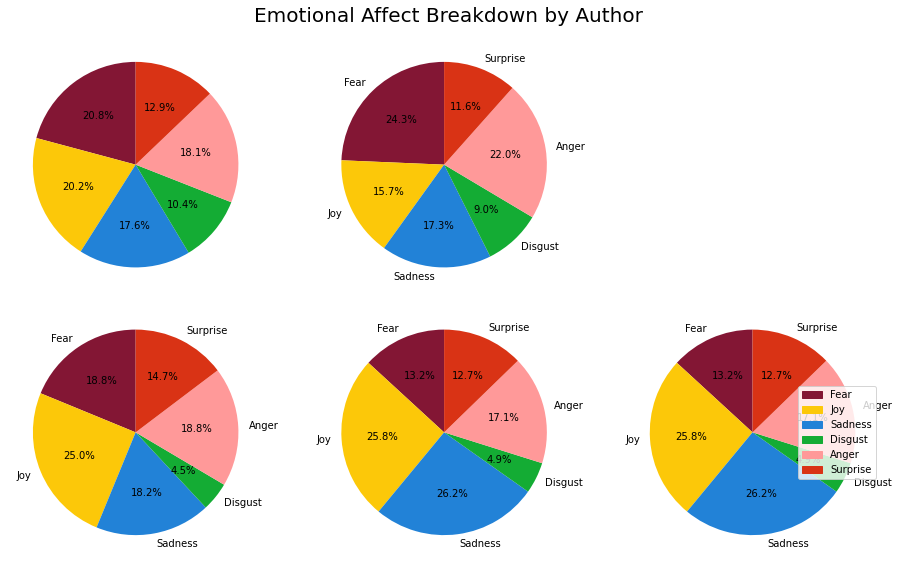

In [246]:
#Transposing the dataframe
emo_df_viz = emo_df.transpose()
emo_df_viz.columns = emo_df_viz.iloc[0]
emo_df_viz = emo_df_viz[1:]

#Plotting the Graphs
fig, ax = plt.subplots(figsize=(13,8))
labels = ['Fear', 'Joy', 'Sadness', 'Disgust', 'Anger', 'Surprise']
colors = ['#831634','#FCC809','#2282D7','#14AC34', '#ff9999','#D93315']
plt.suptitle('Emotional Affect Breakdown by Author', fontsize=20)

plt.subplot(2, 3, 1)
marx = plt.pie(emo_df_viz['Marx'],colors=colors, autopct='%1.1f%%', startangle=90)
plt.subplot(2, 3, 2)
lenin = plt.pie(emo_df_viz['Lenin'], labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

plt.subplot(2, 3, 4)
keynes = plt.pie(emo_df_viz['Keynes'], labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.subplot(2, 3, 5)
ricardo = plt.pie(emo_df_viz['Ricardo'], labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.subplot(2, 3, 6)
smith = plt.pie(emo_df_viz['Ricardo'], labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

#Legend
fear = mpatches.Patch(color='#831634', label='Fear')
joy = mpatches.Patch(color='#FCC809', label='Joy')
sad = mpatches.Patch(color='#2282D7', label='Sadness')
disgust = mpatches.Patch(color='#14AC34', label='Disgust')
anger = mpatches.Patch(color='#ff9999', label='Anger')
surprise = mpatches.Patch(color='#D93315', label='Surprise')


plt.tight_layout()
plt.legend(handles=[fear,joy,sad,disgust,anger,surprise], loc='center right')